# Trabajo Computacional 3

###### Alumnos: Guido Salustri, Lucas Miranda, Ezequiel Sosa, Claudio Schuster

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### 1) Considere la red social de 62 delfines de Nueva Zelanda (dolphins.txt, dolphins.gml, dolphinsGender.txt):

In [8]:
import louvain, time, igraph, itertools, json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
plt.rcParams['figure.figsize'] = (16,12)

In [3]:
def calculate_infomap(np_adj_list, method="infomap"):
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    t0=time.time()
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership
#    labels = g.community_label_propagation(weights="weight").membership
    if method=="fastgreedy":
        labels = g.community_fastgreedy(weights="weight").as_clustering().membership
          
    #print("Duración: {}s".format(time.time()-t0))
           
    return labels

from __future__ import division

from functools import wraps
from itertools import product

import networkx as nx
from networkx import NetworkXError
from networkx.utils import not_implemented_for
from networkx.algorithms.community.community_utils import is_partition

__all__ = ['coverage', 'modularity', 'performance']

               
class NotAPartition(NetworkXError):
    """Raised if a given collection is not a partition.

    """

    def __init__(self, G, collection):
        msg = '{} is not a valid partition of the graph {}'
        msg = msg.format(G, collection)
        super(NotAPartition, self).__init__(msg)


def modularity(G, communities, weight='weight'):
    r"""Returns the modularity of the given partition of the graph.

    Modularity is defined in [1]_ as

    .. math::

        Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)
            \delta(c_i,c_j)

    where $m$ is the number of edges, $A$ is the adjacency matrix of
    `G`, $k_i$ is the degree of $i$ and $\delta(c_i, c_j)$
    is 1 if $i$ and $j$ are in the same community and 0 otherwise.

    Parameters
    ----------
    G : NetworkX Graph

    communities : list
        List of sets of nodes of `G` representing a partition of the
        nodes.

    Returns
    -------
    Q : float
        The modularity of the paritition.

    Raises
    ------
    NotAPartition
        If `communities` is not a partition of the nodes of `G`.

    Examples
    --------
    >>> G = nx.barbell_graph(3, 0)
    >>> nx.algorithms.community.modularity(G, [{0, 1, 2}, {3, 4, 5}])
    0.35714285714285704

    References
    ----------
    .. [1] M. E. J. Newman *Networks: An Introduction*, page 224.
       Oxford University Press, 2011.

    """
    if not is_partition(G, communities):
        raise NotAPartition(G, communities)

    multigraph = G.is_multigraph()
    directed = G.is_directed()
    m = G.size(weight=weight)
    if directed:
        out_degree = dict(G.out_degree(weight=weight))
        in_degree = dict(G.in_degree(weight=weight))
        norm = 1 / m
    else:
        out_degree = dict(G.degree(weight=weight))
        in_degree = out_degree
        norm = 1 / (2 * m)

    def val(u, v):
        try:
            if multigraph:
                w = sum(d.get(weight, 1) for k, d in G[u][v].items())
            else:
                w = G[u][v].get(weight, 1)
        except KeyError:
            w = 0
        # Double count self-loops if the graph is undirected.
        if u == v and not directed:
            w *= 2
        return w - in_degree[u] * out_degree[v] * norm

    Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))
    return Q * norm

def distancia_cluster(G,nodo,lista_nodos, mode='average'):
    """
    promedio de los caminos mas cortos
    """
    distancias = [nx.algorithms.shortest_paths.generic.shortest_path_length(G,nodo,target) 
                  for target in lista_nodos]
    
    if mode == 'average':
        return sum(distancias) * 1.0 / len(distancias)
    elif mode == 'min':
        return min(distancias)
    
def silhouette_nodo(G,nodo, partitions):
    """
    b = min(c(i))
    a - b / max(a,b)
    """    
    cs = []
    for partition in partitions:
        if nodo in partition:
            a = distancia_cluster(G,nodo,partition)
        else:
            c = distancia_cluster(G,nodo,partition)
            cs.append(c)
    
    b = min(cs)    
    return (b - a) / max([a,b])
    
    
def silhouette_grafo(G,partitions):
    """
    partitions: lista de listas
    """
    
    return {nodo:silhouette_nodo(G,nodo,partitions) for nodo in G.nodes}
    


In [4]:
G=nx.read_gml("./dolphins.gml")

#### a. Encuentre la partición en clusters de esta red utilizando la metodología Louvain, infomap, fast_greedy y edge_betweenness. Visualice los resultados gráficamente.

Se describen en primer lugar los algoritmos a utilizar:

Infomap: se basa en minimizar la cantidad de memoria necesaria para describir una caminata al azar de n pasos en una dada red y utiliza esto como criterio para encontrar la mejor partición en clusters de la red. Los pasos de la caminata al azar siempre van a  ser más probables a suceder dentro de clusters que entre clusters, es decir el caminante pasa más tiempo caminando dentro de un cluster y es poco frecuente que cambie de clusters, esto por supuesto si la partición es buena. Por lo cual, la forma de optimizar la memoria utilizada es indexar en dos niveles: uno para pasar de un cluster a cluster y el otro para pasos dentro de los propios clusters, que son los pasos más frecuentes. Esto permite utilizar etiquetas más cortas y también repetirlas.

Fastgreedy: clusteriza asumiendo primero un cluster por nodo, luego para cada par de clusters conectados por al menos un enlace calcula la diferencia de valor de modularidad que habría si considerara cluster único a ese par. Cuando encuentra un par que maximiza dicha diferencia une dicho par como un solo cluster, guarda la partición y el valor de modularidad nuevo y repite todo el proceso de manera iterativa hasta que se obtiene un solo cluster. Luego se elige aquella partición guardada que tenga el mayor valor de modularidad.

Louvain: ocurre en dos fases repetidas iterativamente. En la primera, asumiendo un cluster por nodo, para cada nodo calcula la diferencia de modularidad obtenida si ese nodo se lo considerara parte del cluster de cada uno de sus vecinos. Luego, si hay algún vecino con el que la diferencia de modularidad sea positiva, agrupa en un mismo cluster el nodo con el vecino con el que resulte un mayor aumento de modularidad. Este proceso lo repite para todos los nodos. Cuando los examinó todos comienza la segunda fase, donde genera una nueva red en la que cada nodo es un cluster obtenido en la fase anterior, los enlaces internos son representados como autoenlaces y en caso de existir múltiples enlaces entre dos clusters, estos se representan como uno solo pero pesado. Las fases 1 y 2 se repiten de vuelta sobre esta nueva red, y así de modo iterativo hasta que no se pueden obtener aumentos de modularidad y se obtienen los clusters definitivos.

Edge Betweenness: el criterio para clusterizar de Newman-Grivan es a partir de la remoción de enlaces de la red con altos valores de betweenness es decir enlaces por los cuales muchos nodos se conectan atravesando el camino más corto posible. Mediante este procedimiento la red se va partiendo en componentes que pasan a ser definidos como clusters. Como citrio de corte se busca maximizar la modularidad y se selecciona dicha partición.

In [5]:
#Infomap
infomap_membership = calculate_infomap(nx.to_numpy_matrix(G))
infomap_dict = {str(i):v for i,v in enumerate(infomap_membership)}
fastgreedy_membership = calculate_infomap(nx.to_numpy_matrix(G), method='fastgreedy')
fastgreedy_dict = {str(i):v for i,v in enumerate(fastgreedy_membership)}

In [6]:
nx.set_node_attributes(G,infomap_dict,'infomap')
nx.set_node_attributes(G,fastgreedy_dict,'fastgreedy')

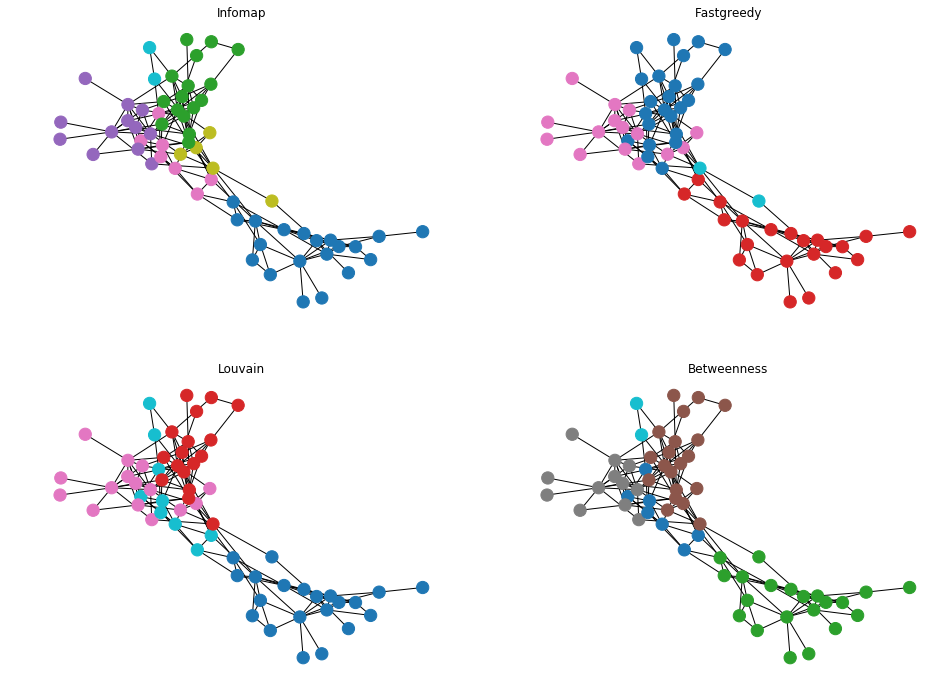

In [9]:
#Graficamos teniendo en cuenta los clusters (infomap)
pos = nx.spring_layout(G)
plt.subplot(221)
nx.draw(G,node_size=150, node_color=infomap_membership, cmap = plt.get_cmap('tab10'), pos = pos)
plt.title('Infomap')

plt.subplot(222)

#Graficamos teniendo en cuenta los clusters (fastgreedy)
nx.draw(G,node_size=150, node_color=fastgreedy_membership, cmap = plt.get_cmap('tab10'), pos = pos)
plt.title('Fastgreedy')

plt.subplot(223)


#Louvain
g = igraph.Graph.Weighted_Adjacency(nx.to_numpy_matrix(G).tolist(),mode=igraph.ADJ_UPPER)
parts = louvain.find_partition(g, louvain.ModularityVertexPartition)
parts=list(parts)
louvain_membership=list(range(len(G))) 
for k in range(len(parts)):
    for t in parts[k]:
        louvain_membership[t]=k
        
louvain_dict = {str(i):v for i,v in enumerate(louvain_membership)}
nx.set_node_attributes(G,infomap_dict,'louvain')

#Graficamos teniendo en cuenta los clusters (Louvain)
nx.draw(G,node_size=150, node_color=louvain_membership, cmap = plt.get_cmap('tab10'), pos = pos)
plt.title('Louvain')

plt.subplot(224)

#Edge Bettweeness

comunidades = list(nx.algorithms.community.girvan_newman(G))

betweenness_membership = [0 for _ in range(len(G))]
nombre_id = {n:i for i,n in enumerate(list(G.nodes))}
for num_grupo,grupo in enumerate(comunidades[3]):
    for nodo in grupo:
        betweenness_membership[nombre_id [nodo]  ] = num_grupo

#betweenness_dict = {str(i):v for i,v in enumerate(betweenness_membership)}
#nx.set_node_attributes(G,betweenness_dict,'betweenness')

#Graficamos teniendo en cuenta los clusters (betweenness)

nx.draw(G,node_size=150, node_color=betweenness_membership, cmap = plt.get_cmap('tab10'), pos = pos)
plt.title('Betweenness')

plt.show()

#### b. Caracterice las particiones obtenidas en términos de modularidad y silhouette de cada particion. Compare con valores esperados en redes recableadas y establezca si tiene derecho a llamar modular a esta red.


In [10]:
particiones = ["infomap","betweenness","fastgreedy","louvain"]

def calcular_particion(nombre,grafo):
    """Devuelve las particiones de óptimas de la red por el método especificado"""
    
    if nombre == "betweenness":
        particiones = list(nx.algorithms.community.girvan_newman(grafo))
        modularidades = [modularity(grafo,i) for i in particiones if len(i)>1]
        return particiones[np.argmax(modularidades)]
    
    elif nombre == "louvain":
        igrafo = igraph.Graph.Weighted_Adjacency(nx.to_numpy_matrix(grafo).tolist(),mode=igraph.ADJ_UPPER)
        particion = list(louvain.find_partition(igrafo, louvain.ModularityVertexPartition))
        name_dict = {i:name for i,name in enumerate(list(grafo.nodes()))}

        iparticion = []
        for i,j in enumerate(particion):
            icomunidad = []
            for k in j:
                icomunidad.append(name_dict[k])
            iparticion.append(icomunidad)
        return iparticion
    
    elif nombre == "infomap":
        particion = calculate_infomap(nx.to_numpy_matrix(grafo))
        name_dict = {i:name for i,name in enumerate(list(grafo.nodes()))}
        
        iparticion = [[] for i in range(max(particion)+1)]
        for i,j in enumerate(particion):
            iparticion[j].append(name_dict[i])
        
        return iparticion
        
    elif nombre == "fastgreedy":
        particion = calculate_infomap(nx.to_numpy_matrix(grafo), method='fastgreedy')
        name_dict = {i:name for i,name in enumerate(list(grafo.nodes()))}
        
        iparticion = [[] for i in range(max(particion)+1)]
        for i,j in enumerate(particion):
            iparticion[j].append(name_dict[i])
        
        return iparticion
        

modularity_random_dict = {k:[] for k in particiones}
silhouette_random_dict = {k:[] for k in particiones}
posta_mod_list = []
posta_sil_list = []

for nombre in particiones:
    p = calcular_particion(nombre,G)
    posta_mod = nx.algorithms.community.modularity(G, p)
    posta_sil = np.mean( list( silhouette_grafo(G, p).values() ))
    posta_mod_list.append(posta_mod)
    posta_sil_list.append(posta_sil)
    
    random_graphs = [nx.algorithms.swap.double_edge_swap(G.copy(),nswap=500,max_tries=1000)
                    for _ in range(500) ]
    random_graphs = [x for x in random_graphs if len(list(nx.connected_components(x))) == 1]
    
    mod_random = []
    sil_random = []
    
    for rg in tqdm(random_graphs):
        
        rpartitions = calcular_particion(nombre,rg)
        
        if len(rpartitions)<6:
            continue
        
        mod = nx.algorithms.community.modularity(rg, rpartitions)
        sil = np.mean( list( silhouette_grafo(rg, rpartitions).values() ))
        mod_random.append(mod)
        sil_random.append(sil)
    modularity_random_dict[nombre] += mod_random
    silhouette_random_dict[nombre] += sil_random
    
    #print ([nombre,posta_mod,posta_sil,max(mod_random),max(sil_random),np.mean(mod_random),np.mean(sil_random)])

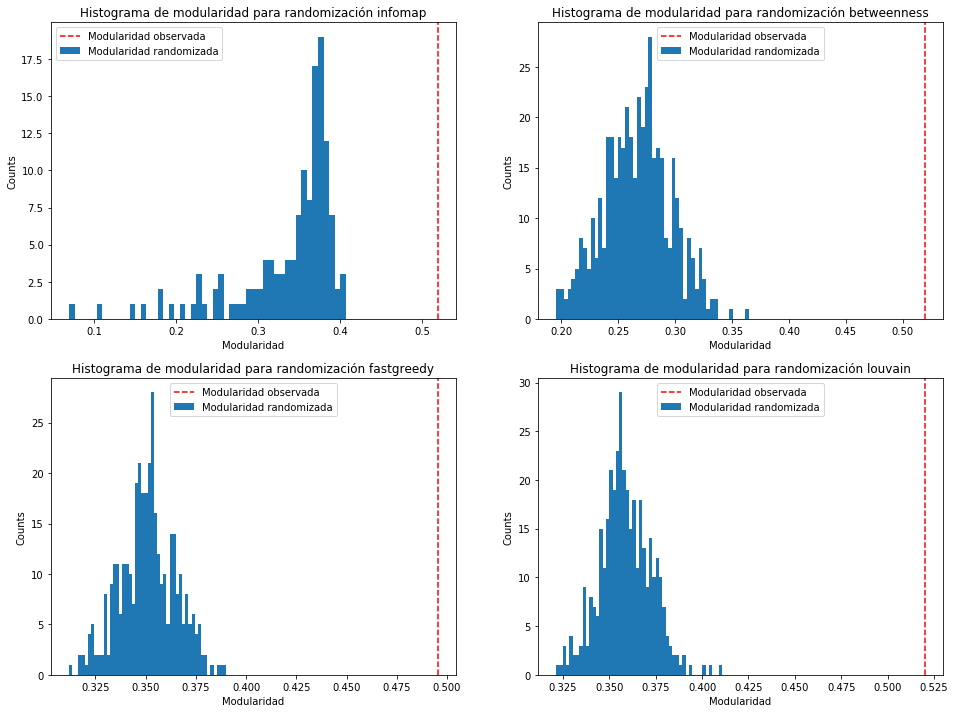

In [11]:
#Graficamos los histogramas de modularidad para cada randomización, junto con el valor de la partición óptima
plt.rcParams['figure.figsize'] = (16,12)

plt.subplot(221)
plt.hist(modularity_random_dict['infomap'],label="Modularidad randomizada", bins=50)
plt.xlabel("Modularidad")
plt.ylabel("Counts")
plt.title("Histograma de modularidad para randomización infomap")
plt.axvline(x=posta_mod_list[0], color='red', linestyle='--',label="Modularidad observada")
plt.legend()

plt.subplot(222)
plt.hist(modularity_random_dict['betweenness'],label="Modularidad randomizada", bins=50)
plt.xlabel("Modularidad")
plt.ylabel("Counts")
plt.title("Histograma de modularidad para randomización betweenness")
plt.axvline(x=posta_mod_list[1], color='red', linestyle='--',label="Modularidad observada")
plt.legend()

plt.subplot(223)
plt.hist(modularity_random_dict['fastgreedy'],label="Modularidad randomizada", bins=50)
plt.xlabel("Modularidad")
plt.ylabel("Counts")
plt.title("Histograma de modularidad para randomización fastgreedy")
plt.axvline(x=posta_mod_list[2], color='red', linestyle='--',label="Modularidad observada")
plt.legend()

plt.subplot(224)
plt.hist(modularity_random_dict['louvain'],label="Modularidad randomizada", bins=50)
plt.xlabel("Modularidad")
plt.ylabel("Counts")
plt.title("Histograma de modularidad para randomización louvain")
plt.axvline(x=posta_mod_list[3], color='red', linestyle='--',label="Modularidad observada")
plt.legend()

plt.show()

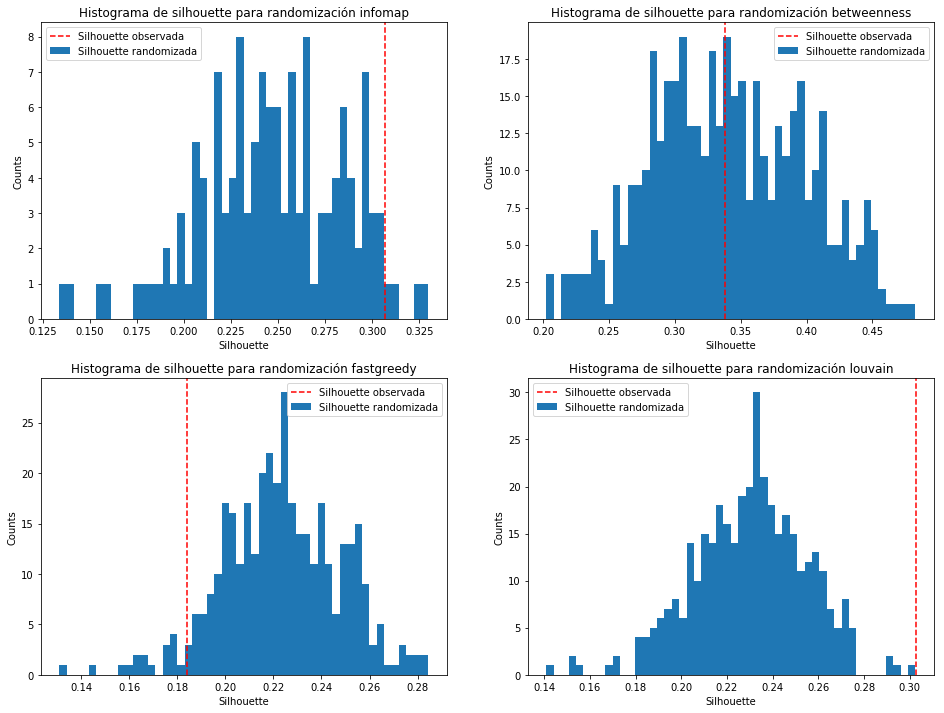

In [12]:
#Graficamos los histogramas de silhouete para cada randomización, junto con el valor de la partición óptima
plt.rcParams['figure.figsize'] = (16,12)

plt.subplot(221)
plt.hist(silhouette_random_dict['infomap'],label="Silhouette randomizada", bins=50)
plt.xlabel("Silhouette")
plt.ylabel("Counts")
plt.title("Histograma de silhouette para randomización infomap")
plt.axvline(x=posta_sil_list[0], color='red', linestyle='--',label="Silhouette observada")
plt.legend()

plt.subplot(222)
plt.hist(silhouette_random_dict['betweenness'],label="Silhouette randomizada", bins=50)
plt.xlabel("Silhouette")
plt.ylabel("Counts")
plt.title("Histograma de silhouette para randomización betweenness")
plt.axvline(x=posta_sil_list[1], color='red', linestyle='--',label="Silhouette observada")
plt.legend()

plt.subplot(223)
plt.hist(silhouette_random_dict['fastgreedy'],label="Silhouette randomizada", bins=50)
plt.xlabel("Silhouette")
plt.ylabel("Counts")
plt.title("Histograma de silhouette para randomización fastgreedy")
plt.axvline(x=posta_sil_list[2], color='red', linestyle='--',label="Silhouette observada")
plt.legend()

plt.subplot(224)
plt.hist(silhouette_random_dict['louvain'],label="Silhouette randomizada", bins=50)
plt.xlabel("Silhouette")
plt.ylabel("Counts")
plt.title("Histograma de silhouette para randomización louvain")
plt.axvline(x=posta_sil_list[3], color='red', linestyle='--',label="Silhouette observada")
plt.legend()

plt.show()

In [14]:
#Por último, hacemos una tabla con los valores de modularidad y silhouette óptimos, media y desvío de los datos randomizados
#y el p-valor correspondiente

Partition_df = pd.DataFrame({'Modularidad real':[i for i in posta_mod_list],
                             'Modularidad randomizada media':[np.mean(i) for i in modularity_random_dict.values()],
                             'Modularidad randomizada sd':[np.std(i) for i in modularity_random_dict.values()],
                             'p-value mod':[np.min([len([i for i in j if i >= posta_mod_list[k]])/len(list(j)),
                                            len([i for i in j if i <= posta_mod_list[k]])/len(list(j))])
                                            for k,j in enumerate(modularity_random_dict.values())],
                             'Silhouette real':[i for i in posta_sil_list],
                             'Silhouette randomizada media':[np.mean(i) for i in silhouette_random_dict.values()],
                             'Silhouette randomizada sd':[np.std(i) for i in silhouette_random_dict.values()],
                             'p-value sil':[np.min([len([i for i in j if i >= posta_sil_list[k]])/len(list(j)),
                                            len([i for i in j if i <= posta_sil_list[k]])/len(list(j))])
                                            for k,j in enumerate(silhouette_random_dict.values())]})

Partition_df.rename(index={i:v for i,v in enumerate(particiones)}, inplace=True)

Partition_df    

,Modularidad real,Modularidad randomizada media,Modularidad randomizada sd,p-value mod,Silhouette real,Silhouette randomizada media,Silhouette randomizada sd,p-value sil
infomap,0.518947,0.336140,0.062318,0.0,0.306852,0.247419,0.037688,0.022388
betweenness,0.519382,0.266717,0.029458,0.0,0.338110,0.340062,0.058425,0.498871
fastgreedy,0.495491,0.350918,0.013807,0.0,0.183928,0.223275,0.024448,0.048518
louvain,0.520114,0.358659,0.013780,0.0,0.302628,0.230003,0.024682,0.000000


Se comparó los valores de modularidad y silhouette de cada partición obtenida con las respectivas particiones de una distribución de 500 redes recableadas al azar (respetando el grado de los nodos), con el fin de evaluar cuán modulares eran las particiones. Para el caso de modularidad de la red, todos los criterios dieron significativamente mayor a la de las distribuciones de las redes recableadas al azar, por lo cual podríamos afirmar que se trata de una red modular. Sin embargo, para el silhouette  el criterio de Newman-Grivan no difiere significativamente de la distribución de redes recableadas al azar y fast greedy da incluso un valor de silhouette más bajo que la media de la distribución de redes recableadas al azar. Para los otros dos criterios, Louvain y infomap, si se observa una diferencia significativa entre la partición de la red y la distribución de redes recableadas al azar sinedo mayor el valor de la red real.

#### c. Caracterice cuantitativamente el acuerdo entre las particiones obtenidas utilizando uno o más de los observables vistos en clase.


In [15]:
def Info_mutua(partition_list, Norm=False):
    """Devuelve la información mutua entre las particiones ingresadas"""
    
    Num_clusters = {k:np.max(v)+1 for k,v in enumerate(partition_list)}
    clusters = [[i for i in range(np.max(j)+1)] for j in partition_list]
    Cluster_combinations = list(itertools.product(*clusters))
    
    #Calculamos la probabilidad de cada cluster en cada particion
    Prob_clusters = []
    for p,i in enumerate(partition_list):
        partition_probs = []
        for j in range(np.max(i)+1):
            partition_probs.append(len([k for k in i if k==j])/len(i))
        Prob_clusters.append(partition_probs)
        
    Disjoint_prob_matrix = np.zeros(list(Num_clusters.values()))
    for combination in Cluster_combinations:
        Disjoint_prob_matrix[combination] = np.prod([Prob_clusters[i][j] for i,j in enumerate(combination)])
        
    #Calculamos la probabilidad conjunta entre todos los clusters y particiones
    Joint_prob_matrix = np.zeros(list(Num_clusters.values()))
    
    for combination in Cluster_combinations:
        Joint_count = len([i for i in range(len(partition_list[0])) if list(zip(*partition_list))[i] == combination])
        Joint_prob_matrix[combination] = Joint_count/len(partition_list[0])
            
    #Finalmente, calculamos el valor de información mutua entre las particiones ingresadas
    Mutual_information = np.sum(Joint_prob_matrix * np.log(Joint_prob_matrix/Disjoint_prob_matrix+float(1e-200)))
    
    if Norm == True:
        #Calculamos la entropía de Shannon
        Shannon_sum = np.sum([[-np.sum(np.array(i)*np.log(np.array(i)))] for i in Prob_clusters])
        
        return np.round(2*Mutual_information/Shannon_sum,3)
    
    return np.round(Mutual_information,3)

In [16]:
particiones = [infomap_membership,betweenness_membership,fastgreedy_membership,louvain_membership]
Comparations = list(itertools.combinations_with_replacement(particiones,2))
Mutual_Info_dict = {str(k):[Info_mutua(v,Norm=True) for v in Comparations if k in v] for k in particiones}
Mutual_Info_df = pd.DataFrame(Mutual_Info_dict)
Mutual_Info_df.columns = ['Infomap','Betweenness','Fastgreedy','Louvain']
Mutual_Info_df.index = ['Infomap','Betweenness','Fastgreedy','Louvain']
Mutual_Info_df

,Infomap,Betweenness,Fastgreedy,Louvain
Infomap,1.000,0.911,0.768,0.864
Betweenness,0.911,1.000,0.662,0.878
Fastgreedy,0.768,0.662,1.000,0.778
Louvain,0.864,0.878,0.778,1.000


El acuerdo entre las particiones se caracterizó utilizando el criterio de información mutua, que nos habla de cuánta información puedo obtener de un dado nodo a partir de una dada partición con respecto a la otra. Lo resultados se observan el la tabla, siendo infomap la que muestra mayor acuerdo con todas las otras particiones, y en particular se maximiza con louvain con un valor de 0,873. Las particiones que resultan en el menor acuerdo o que pueden explicar menos una con respecto a la otra son Betweenness y Fastgreedy con un valor de información mutua de 0,662.

#### d. Analice cuantitativamente la relación entre el género de los delfines y la estructura de comunidades del grupo. Puede utilizar para ello, por ejemplo, tests de sobre-representación y/o sub-representacion. Qué hipótesis puede aventurar sobre propiedades comportamentales de este grupo de delfines a partir de lo encontrado?

In [17]:
G=nx.read_gml("./dolphins.gml")
sexos = {x.split()[0].strip():x.split()[1].strip() for x in open("./dolphinsGender.txt")}
nombre_parts = ["infomap","betweenness","fastgreedy","louvain"]
particiones = { }
for i,p in enumerate(open("./Particiones.txt").read().split("\n")): 
    if p:
        data = p.strip().replace("'",'"')
        data = data.replace("{","[").replace("}","]").replace("(","[").replace(")","]")        
        v = json.loads(data)
        particiones[nombre_parts[i]] = v 

In [18]:
import operator as op
from functools import reduce
import math

def ncr(n, p):
    
    return  math.factorial(n) / ( math.factorial(p) * (math.factorial(n-p) ))

def mipvalue(k,m,N,r):  
    values = []
    for m2 in range(m,k):     
        
        val = (ncr(k,m2) * (ncr(N-k,r-m2)) ) / (ncr(N,r))
        values.append(val)
    return sum(values)

In [19]:
table = []
for nombre,grupos in particiones.items():
    
    for idx_grupo, grupo in enumerate(grupos):
        for sexo in ["m","f"]:
            subgrupo_ok = len([delfin for delfin in grupo if sexo == sexos[delfin]])
            subgrupo_nok = len(grupo) - subgrupo_ok
            fueragrupo = [delfin for delfin in G.nodes() if delfin not in grupo]
            fueragrupo_ok = len([delfin for delfin in fueragrupo if sexo == sexos[delfin]])
            fueragrupo_nok = len(fueragrupo) - fueragrupo_ok
            sexona = len([delfin for delfin in grupo if 'NA' == sexos[delfin]])
            sexo_c = len([delfin for delfin in G.nodes() if sexo == sexos[delfin]])
            
            if subgrupo_ok:
                
                pvalue = mipvalue(len(grupo),subgrupo_ok,
                                 62,sexo_c)
            else:
                pvalue = np.NaN
                subgrupo_ok, subgrupo_nok, fueragrupo_ok, fueragrupo_nok = (np.NaN,np.NaN,np.NaN,np.NaN)
                
            table.append([nombre,idx_grupo,len(grupo), sexo ,pvalue,sexona ,
                         subgrupo_ok, subgrupo_nok, fueragrupo_ok, fueragrupo_nok
                         ])

df = pd.DataFrame(table, columns=["algoritmo","grupo","tam_grupo","sexo","p-value","sexo_na",
                                 "subgrupo_ok","subgrupo_nok","fueragrupo_ok","fueragrupo_nok"
                                 
                                 ])

df

,algoritmo,grupo,tam_grupo,sexo,p-value,sexo_na,subgrupo_ok,subgrupo_nok,fueragrupo_ok,fueragrupo_nok
0,infomap,0,23,m,0.999449,1,7.0,16.0,27.0,12.0
1,infomap,0,23,f,0.001244,1,15.0,8.0,9.0,30.0
2,infomap,1,22,m,0.001508,2,18.0,4.0,16.0,24.0
3,infomap,1,22,f,0.999979,2,2.0,20.0,22.0,18.0
4,infomap,2,15,m,0.437298,1,9.0,6.0,25.0,22.0
5,infomap,2,15,f,0.784977,1,5.0,10.0,19.0,28.0
6,infomap,3,2,m,NaN,0,NaN,NaN,NaN,NaN
7,infomap,3,2,f,0.000000,0,2.0,0.0,22.0,38.0
8,betweenness,0,20,m,0.005828,2,16.0,4.0,18.0,24.0
9,betweenness,0,20,f,0.999904,2,2.0,18.0,22.0,20.0


En la tabla se muestra el resultado de probar el enriquecimiento de los sexos "m" o "f" 
sobre cada una de las particiones obtenidas en una corrida particular de cada algoritmo. Para ello se aplico el test de exacto de fisher en cada una de las particiones y se obtuvo el p-value de cada combinación. Se puede ver rápidamente que cuando dicho valor cae por debajo de 0.01 en un sexo, es mayor a 0.8 en el otro.

C:\Users\l_vey\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


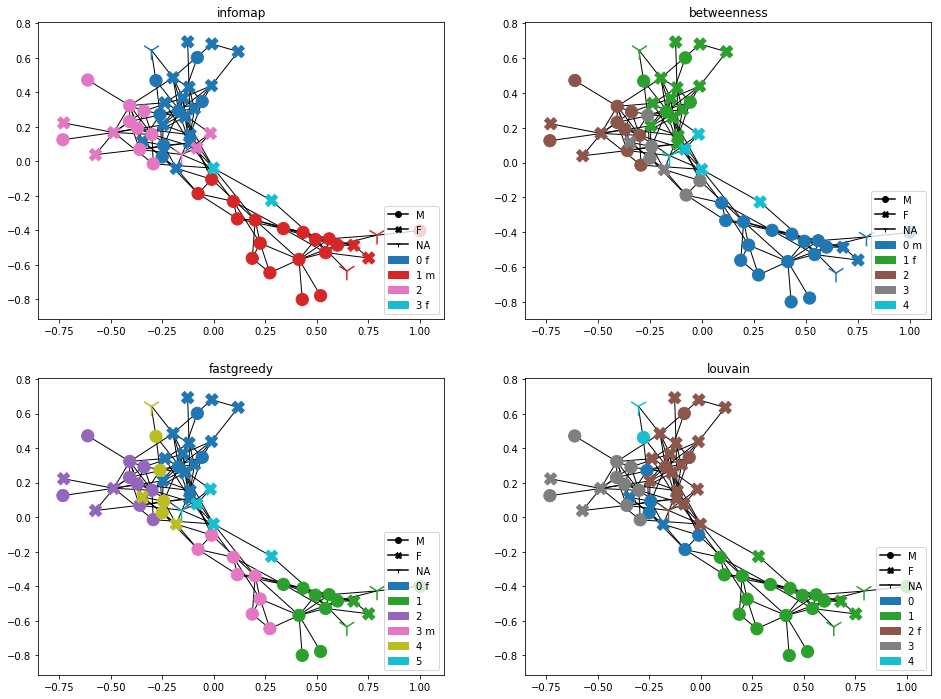

In [20]:
cmap = plt.get_cmap('tab10')
shape = {
    "m":"o",
    "f":"X",
    "NA":"1"
}

# colors = ["blue","green","yellow","black","red","grey"]

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

subplots = [plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)]

for gidx,(nombre,grupos) in enumerate(particiones.items()):
    
    nx.draw_networkx_edges(G,pos=pos,ax=subplots[gidx])
    
    colors = [cmap(x) for x in np.linspace(0,1,len(grupos))]
    patches = [Line2D([0], [0],label="M",marker="o",color="black") 
    ,Line2D([0], [0],label="F",marker="X",color="black") ,Line2D([0], [0],label="NA",marker="1",color="black") ]
    for i,grupo in enumerate(grupos):  
        
        for sexo in ["m","f","NA"]:     
            nodos = [n for n in grupo if sexo == sexos[n]]
            node_colors = [colors[i] for _ in range(len(nodos))]
            
            if nodos:
                nx.draw_networkx_nodes(nodos, node_size=350 if sexo == "NA" else 150,
                                   pos=pos,node_color=node_colors,node_shape=shape[sexo],ax=subplots[gidx])
    
    
        enriquecido = df.dropna()[(df.algoritmo == nombre) & (df.grupo == i) & (df["p-value"] < 0.01)]
        if len(enriquecido):
            enriquecido = enriquecido.iloc[0].sexo
        else:
            enriquecido = ""
        patch = mpatches.Patch(color=colors[i] , label='%i %s' % (i,enriquecido))
        patches.append(patch)
        
    subplots[gidx].set_title(nombre)
    subplots[gidx].legend(handles=patches, loc="lower right")
plt.show()

En estos 4 gráficos se muestran: con figuras el sexo y con colores las particiones obtenidas por una corrida de cada algoritmo, las cuales coinciden con las de la tabla anterior. En la leyenda estan marcadas con una "m" o "f" si dicha particon esta enriquesida (p-value < 0.01) en alguno de los 2 sexos.
Si uno quisiese proponer la hipótesis de que las particiones reflejan cierta homofilia por sexo, con estas corridas, solo el algoritmo infomap genera mayor porcentaje de grupos que la cumplen. 
Tambien "parece" haber un consenso en: (las particiones se parecen)
- infomap-particion1 y betweenness-particion0: enriquecidas en "m"
- infomap-p0, betweenness-p1, fastgreedy-p0 y louvain-p2: enriquesidas en "f"



In [21]:
import random
nx.set_node_attributes(G,sexos,"sexo")
assortatibity = nx.attribute_assortativity_coefficient(G,"sexo")
sexos2 = {}
sexos2.update(sexos)
for _ in range(len(sexos)):
    i1 = random.choice(list(sexos))
    i2 = random.choice(list(sexos))
    x = sexos2[i1]
    sexos2[i1] = sexos2[i2]
    sexos2[i2] = x
nx.set_node_attributes(G,sexos2,"sexo")
assortatibity_rand = nx.attribute_assortativity_coefficient(G,"sexo")
print("%0.2f assortativity vs %0.2f assortativity random" % (assortatibity,assortatibity_rand))

0.24 assortativity vs -0.15 assortativity random


Haciendo un calculo rápido, se calculo la asortatividad de la red por sexo para la red real y luego se recalculo el valor intercambiando los sexos al azar. Con esto vemos que dicha metrica es mayor en la red original.
Si bien en base a esto podemos interpretar que la red presenta homofilia, ello no se cumple en todas las particiones, depende del algoritmo el grado en el que eso pasa. 

In [22]:
from collections import defaultdict
sin_sexo = {delfin:[] for delfin in G.nodes()  if sexos[delfin] == "NA"}
df = df.dropna()
table = []
for _,r in df[(df['p-value'] < 0.05) & (df.sexo_na > 0)].iterrows():
    #[(df.pvalue < 0.1) & (df.sexona > 0)]
    for delfin in list(set(sin_sexo) &  set(particiones[r.algoritmo][r.grupo] )):
        sin_sexo[delfin].append([r.sexo,r.algoritmo,r['p-value']])
        table.append([delfin,r.sexo,r.algoritmo,r['p-value']])
pd.DataFrame(table,columns=["delfin","sexo","algoritmo","p-value"]).sort_values("delfin")        

,delfin,sexo,algoritmo,p-value
1,Ripplefluke,m,infomap,0.001508
3,Ripplefluke,m,betweenness,0.005828
6,Ripplefluke,m,louvain,0.014791
2,TR82,m,infomap,0.001508
4,TR82,m,betweenness,0.005828
7,TR82,m,louvain,0.014791
0,TSN83,f,infomap,0.001244
5,TSN83,f,betweenness,0.000762
8,Zap,f,louvain,0.000006


Finalmente, observando donde se encuentran los distintos delfines cuyo sexo no pudo ser determinado, en varios casos existe un consenso entre las particones de distintos algorimos y su enriquecimiento en un determinado sexo. Esto podra usarse para arriesgar dicha característica de los delfines en cuestión. Por ejemplo Ripplefluke esta tanto en particiones generadas por infomap,betweenness y louvain enriquecidas en sexo masculino.